##ResNetV2 model for Feelbeat

In [ ]:
!pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
!pip install scikit-image
!pip install pydot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

In [ ]:

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
from tensorflow.keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize
from tensorflow.keras.applications import ResNet50V2

import pydot


In [ ]:
EPOCHS = 50
BS = 64
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 164

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck+_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train_jaffe.zip' -d train




In [ ]:

! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test_com.zip' -d test


In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-public.zip' -d dev

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(224, 224),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator = get_datagen('/content/train',True)
# dev_generator = get_datagen('/content/dev')
test_generator =get_datagen('/content/test')

Found 30533 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:

# Load the ResNet50V2 model
resnet50v2_notop = ResNet50V2(include_top=False, weights='imagenet', input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')

# Get the output from the last layer
last_layer = resnet50v2_notop.output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

# Assuming that you have determined the indices for BatchNorm layers in ResNet50V2
# You can get them with the following line:
batch_norm_indices = [i for i, layer in enumerate(resnet50v2_notop.layers) if 'BatchNormalization' in layer.__class__.__name__]

# Freeze the layers up to a certain index, while keeping the BatchNorm layers trainable
FROZEN_LAYER_NUM = 164  # This number should be adapted to ResNet50V2
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        resnet50v2_notop.layers[i].trainable = False

# Add a new classifier layer
out = Dense(7, activation='softmax', name='classifier')(x)

# Create the model
model = Model(inputs=resnet50v2_notop.input, outputs=out)

# Optimizer
initial_learning_rate_optim = ADAM_LEARNING_RATE
learning_rate_schedule_optim = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_optim,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule_optim)


# Add callbacks
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
callbacks_list = [rlrop]

# Compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=test_generator,
    shuffle=True,
    steps_per_epoch = 28709//BS,
    validation_steps = 7178//BS,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    use_multiprocessing=True)

Epoch 1/50
448/448 [==============================] - 454s 960ms/step - loss: 1.4512 - accuracy: 0.4611 - val_loss: 1.8046 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 451s 1s/step - loss: 1.2193 - accuracy: 0.5503 - val_loss: 1.3312 - val_accuracy: 0.5377 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 447s 993ms/step - loss: 1.1198 - accuracy: 0.5909 - val_loss: 1.2075 - val_accuracy: 0.5879 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 451s 1s/step - loss: 1.0505 - accuracy: 0.6173 - val_loss: 1.0790 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 458s 1s/step - loss: 0.9959 - accuracy: 0.6374 - val_loss: 1.2997 - val_accuracy: 0.5891 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 444s 990ms/step - loss: 0.9530 - accuracy: 0.6513 - val_loss: 1.1161 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 7/50
448/448 [==============================] - 4

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 7178 // BS)
print('Test loss, Test acc: ',results_test)



# Evaluate on test data


<ipython-input-14-c758800057d2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_generator, 7178 // BS)


Test loss, Test acc:  [2.9155266284942627, 0.6576451063156128]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


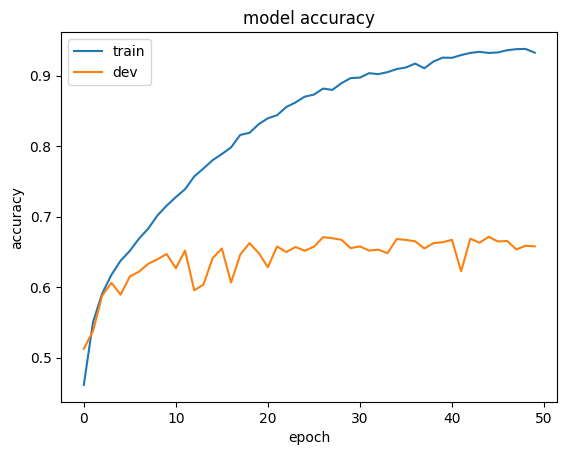

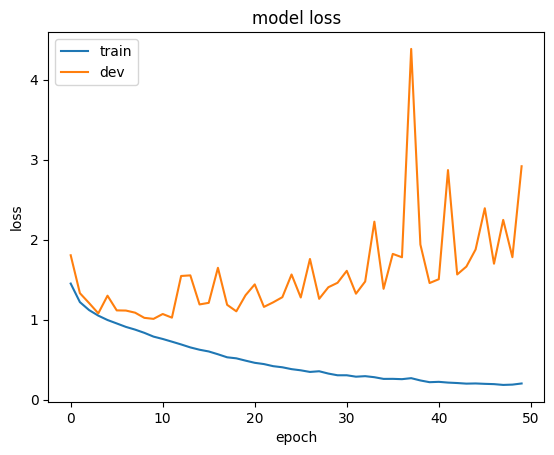

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/CSE499A/models' + 'RESNET50V2' + epoch_str + test_acc + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button").click()
}setInterval(ClickConnect,600000)